<a href="https://colab.research.google.com/github/alexcontarino/personal-projects/blob/main/Sports_Betting/Bonus_Bet_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# When a sportsbook offers a bonus bet promotion, what player strategy optimizes his expected profit?

# The short answer:

# Place an initial wager in the amount of the bonus bet offered and aim for long odds on both the initial wager and the bonus wager. For example, assuming a bonus bet amount of \$5, place a \$5 bet with odds around +760, followed by a bonus bet with similar odds if the first does not hit. This strategy achieves an expected profit around \$3.12 and wins ~20% of the time.

Note that the player can achieve a higher expected profit if he is willing to wait longer to actually win. For example, if he increases the odds on the initial & bonus bets to around +1670, the player achieves a ~\$3.60 expected profit, but only wins ~10% of the time. Even longer odds can reach up to ~\$4 in expected profit but the player will have probably have to wait a while for one of those bets to actually hit. Conversely, initial & bonus bets with odds of +450 end up winning 30% of the time but will only have \$2.65 in expected profit. Trying to achieve higher win probabilities is not recommended. The bonus bet promotion effectively allows you to play with free money--so take advantage of it by being aggressive in your bets.

Exact profits and win rates depend on the charged vig on each bet. Here I assume the player's typical bet is a 2-leg parlay, with 5% vig charged for each leg.

# The Long Answer

## Introduction  

Sportsbook occasionally offer bonus bet promotions: players place a wager on a certain sport or meeting certain other criteria. If the player's bet loses, the sportsbook will give the him a "bonus bet": a non-withdrawal amount of money (usually equal to the player's initially wagered amount, up to some maximum value) that the player can wager again. If the bonus bet hits, the player keeps the profits of this second bet.

The promotion can be represented as so:

An initial wager amount $C$ is placed on a bet with true win probability $q_1$ and offered odds of $v_1$, where $v_1$ is the vig charged by the sportsbook. The player wins

$C (\frac{1 - q_1 v_1}{q_1 v_1})$

with probability $q_1$. If the player's bet loses, then he is afforded the chance to place the bonus bet, with the wager amount usually determined as the minimum value between the initial wager $C$ and the sportsbook's maximum bonus reward, $B$. The player's second chance profits are then

$-C + min(C,B) \frac{1 - q_2 v_2}{q_2 v_2}$

which are won with probability $q_2$ with a charged vig of $v_2$.

The player's expected value from the bonus bet promotion is:

$E[P] = q_1 C (\frac{1 - q_1 v_1}{q_1 v_1}) + (1-q_1) [-C + q_2 min(C,B) (\frac{1 - q_2 v_2}{q_2 v_2})]$

And with some simplification/re-arrangement of terms:

$E[P] = C(\frac{1}{v_1} - 1) + min(C,B)(q_1 q_2 -\frac{q_1}{v_2} - q_2 + \frac{1}{v_2})$

The above equation actually has a nice interpretation that will be more clear after some further discussion below.

But for now, let's focus on answering the key question at hand: if we assume some fixed vig $v_1$, $v_2$, what are the values of $C$, $q_1$, and $q_2$ that maximize $E[P]$? The code below explores this question.


## Set-Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy

## Helper Functions

In [2]:
def prob_to_odds(prb, add_vig=False, vig=1.05):

  # converts probability to American odds
  # user can add a specified vig if desired

  if prb is None:
    return None

  if add_vig:
    prb = prb * vig

  if prb > 0.5:
    odds = math.floor(-100 * prb / (1 - prb))
    return "{}".format(odds)
  else:
    odds = math.ceil(100 * (1 - prb) / prb)
    return "+{}".format(odds)

In [3]:
def profit_calculator(implied_prob, bet_amount):

  # calculates profit from bet given the implied probability (vig charged) and the wager amount

  if implied_prob is None:
    print("Given implied_prob is type None")
    return None

  if implied_prob > 1 or implied_prob < 0:
    print("Invalid implied probability given!")
    return None

  return bet_amount * (1 - implied_prob) / implied_prob

In [4]:
def bonus_bet_exp_profit(q_1, implied_prob_1, q_2, implied_prob_2, C, bonus_bet):

  # calculates expectation of bonus bet promotion using

  ep =  q_1 * profit_calculator(implied_prob_1, C) + (1-q_1) * (-C + q_2*profit_calculator(implied_prob_2, bonus_bet))
  return ep

## Step 1: Compare combinations of $q_1$ and $q_2$

Everything else equal, let's evaluate how $E[P]$ responds to different combinations of true win probabilities on the initial and bonus bet.

What we see is that $E[P]$ increases as $q_1$, $q_2$, or both decrease. Two takeaways from this:

1. The bettor should place bets with long odds with their bonus bet promotion.
1. The relative differences in $q_1$ and $q_2$ do not matter--$E[P]$ is maximized when both are very small

In [5]:
# User Input
num_probs_to_check = 50
true_probs = np.linspace(0.01, 0.99, num_probs_to_check, endpoint=True)  # grid of q_1, q_2 to evaluate
C = 5           # C = initial wager
B = 5           # B = max bonus bet wage amount
v = 1.05**2     # v = vig; assumes the initial and bonus bets are 2-leg parlays with each leg charged a 5% vig

In [6]:
# Evaluate Combos

bonus_bet = np.min([C, B])                      # set bonus bet amount -- in this experiment, C = B

rows_list = []

for q_1 in true_probs:
  implied_prob_1 = np.min([q_1 * v,0.995])      # cap implied probabilities at 0.995 to remain feasibility
  odds_1 = prob_to_odds(implied_prob_1)
  for q_2 in true_probs:
    bet_info = {}
    implied_prob_2 = np.min([q_2 * v,0.995])
    odds_2 = prob_to_odds(implied_prob_2)
    bet_info["Bet"] = C
    bet_info["Prob_1"] = round(q_1,3)
    bet_info["Implied_Prob_1"] = round(implied_prob_1,3)
    bet_info["Odds_1"] = odds_1
    bet_info["Prob_2"] = round(q_2,3)
    bet_info["Implied_Prob_2"] = round(implied_prob_2,3)
    bet_info["Odds_2"] = odds_2
    bet_info["Expected Profit"] = bonus_bet_exp_profit(q_1, implied_prob_1, q_2, implied_prob_2, C, bonus_bet)
    bet_info["Win Perc"] = 1 - (1-q_1)*(1-q_2)

    rows_list.append(bet_info)

df = pd.DataFrame(rows_list)

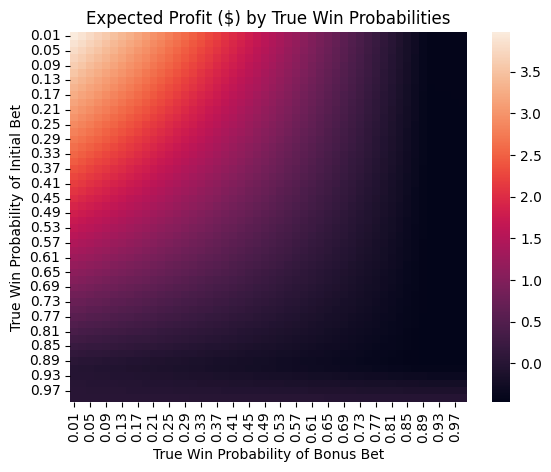

In [7]:
# plot heatmap of E[P] values

df_pivot = df.pivot(index="Prob_1", columns="Prob_2", values="Expected Profit")
sns.heatmap(df_pivot)
plt.xlabel("True Win Probability of Bonus Bet")
plt.ylabel("True Win Probability of Initial Bet")
plt.title("Expected Profit ($) by True Win Probabilities")
plt.show()

## Step 2: Choosing the right $C$

Since we now know that choosing the win probabilities of our initial wagers is fairly straight-forward (make them both small), let's assume that the player places bets such that $q_1$ and $q_2$ are now approximately equal in value. Now we can easily see how $E[P]$ changes in the space of our average bet odds ($ = q_1 = q_2$) vs $C$, the initial wager placed.

What is shown in the code below is that choosing $C = B$ provides the highest $E[P]$, keeping everything else constant.

This result makes sense when compared to the other cases of $C < B$ or $C > B$. If $C < B$, the player leaves money on the table for their potential bonus bet. And when $C$ surpasses $B$, there is a larger penalty for losing the initial wager. This is driven entirely from the vig charged on the initial bet, that is harder for the bonus bet to overcome when $C>B$. Note that, if no vig was charged, then $E[P] \rightarrow min(C,B)$ as $q_1, q_2 \rightarrow 0$, no matter how large $C$ becomes. The user can verify this by running and editing the following code.  

```
q = 0.0001
v = 1.00
implied_prob = q * v
C = 1000000
B = 5

bonus_bet_exp_profit(q, implied_prob, q, implied_prob, C, B)
```

In [8]:
# User Input
B = 5           # B = max bonus bet wage amount
v = 1.05**2     # v = vig; assumes the initial and bonus bets are 2-leg parlays with each leg charged a 5% vig

initial_wagers = B * np.array([0.1, 0.5, 1, 2, 5, 10, 15, 20])                  # grid of C's to evaluate, values computed as multiples of B, the max bonus bet amount
true_probs = np.linspace(0.01, 0.99, len(initial_wagers), endpoint=True)        # grid of true probs to evaluate
                                                                                # This rougher grid is easier to make sense of later, but can certainly be adjusted

In [9]:
# Evaluate Values of C across each true odds

rows_list = []

for q in true_probs:
  for C in initial_wagers:
    bonus_bet = np.min([C, B])
    bet_info = {}
    implied_prob = np.min([q * v,0.995])      # cap implied probabilities at 0.995 to remain feasibility
    odds = prob_to_odds(implied_prob)
    bet_info["Bet"] = round(C,3)
    bet_info["Prob"] = round(q,3)
    bet_info["Implied_Prob"] = round(implied_prob,3)
    bet_info["Odds"] = odds
    bet_info["Expected Profit"] = bonus_bet_exp_profit(q, implied_prob, q, implied_prob, C, bonus_bet)
    bet_info["Win Perc"] = 1 - (1-q)*(1-q)

    rows_list.append(bet_info)

df = pd.DataFrame(rows_list)

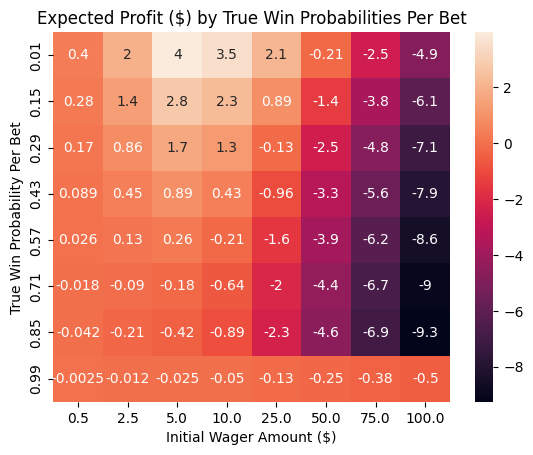

In [10]:
# plot heatmap of E[P] values

annotate_graph = True


df_pivot = df.pivot(index="Prob", columns="Bet", values="Expected Profit")

sns.heatmap(df_pivot, annot=annotate_graph)
plt.xlabel("Initial Wager Amount ($)")
plt.ylabel("True Win Probability Per Bet")
plt.title("Expected Profit ($) by True Win Probabilities Per Bet")
plt.show()

## Discussion

We have so far established that the player can maximize $E[P]$ by setting $C = B$ and by making $q_1$ and $q_2$ as small as possible. While it is great to maximize *expected* winnings in the *long run*, the player is rightly interested in experiencing actual winnings over a non-infinite timeframe. This is somewhat at odds with a blanket recommendation of making $q_1$ and $q_2$ as small as possible.

How to establish some sort of compromise between expected profit and occassionally realizing actual profit is the subject of the portion of this notebook.



## Step 3: Control for Win Probability

In [11]:
B = 5           # B = max bonus bet wage amount
v = 1.05**2     # v = vig; assumes the initial and bonus bets are 2-leg parlays with each leg charged a 5% vig
C = B           # set initial wager amount to B

true_probs = np.linspace(0.01, 0.99, 50, endpoint=True)        # grid of true probs to evaluate

In [12]:
# Evaluate Combos

rows_list = []

bonus_bet = np.min([C, B])

for q in true_probs:
  bet_info = {}
  implied_prob = np.min([q * v,0.995])      # cap implied probabilities at 0.995 to remain feasibility
  odds = prob_to_odds(implied_prob)
  bet_info["Bet"] = C
  bet_info["Prob"] = round(q,3)
  bet_info["Implied_Prob"] = round(implied_prob,3)
  bet_info["Odds"] = odds
  bet_info["Expected Profit"] = bonus_bet_exp_profit(q, implied_prob, q, implied_prob, C, bonus_bet)
  bet_info["Win Perc"] = 1 - (1-q)*(1-q)

  rows_list.append(bet_info)

df = pd.DataFrame(rows_list)

In [13]:
df.sort_values(by="Win Perc", ascending=True).head()

,Bet,Prob,Implied_Prob,Odds,Expected Profit,Win Perc
0,5,0.01,0.011,+8971,3.975443,0.0199
1,5,0.03,0.033,+2924,3.788740,0.0591
2,5,0.05,0.055,+1715,3.606037,0.0975
3,5,0.07,0.077,+1196,3.427334,0.1351
4,5,0.09,0.099,+908,3.252632,0.1719


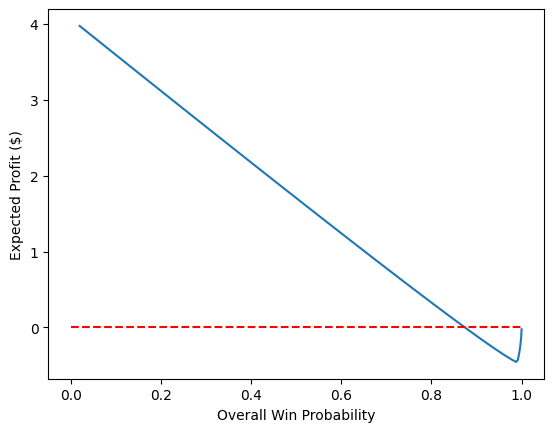

In [14]:
plt.plot(df["Win Perc"], df["Expected Profit"])
plt.plot(np.linspace(0,1,10), np.zeros(10), linestyle="--", color="red")
plt.xlabel("Overall Win Probability")
plt.ylabel("Expected Profit ($)")
plt.show()

Ok, so I was hoping we would be able to see a "bend in the curve" that would allow us to pick a point along win probability where the marginal loss in expected profit becomes untenable. But expected profit is linearly related with overall win probability.

(Note: the spike back toward zero in the bottom right corner is a result of the capping of implied probability calculated for true probabilities very close to 1. This in effect drives the charged vig to 0% for very large probabilities and thus the expected value of the bets back to 0 as well).

This is actually a predictable result looking back at the equations derived in the Introduction section.

The overall win probability, $W$, is calculated as $W = 1 - (1 - q_1)(1 - q_2)$, which when expanded out is $W = 1 - (q_1 q_2 - q_1 - q_2 + 1)$. Note that the latter term is approximately equal to the term $(q_1 q_2 -\frac{q_1}{v_2} - q_2 + \frac{1}{v_2})$ in the simplified equation for $E[P]$. Let's define $x = q_1 q_2 - q_1 - q_2 + 1$ and note $x = 1 - W$. Then:

$E[P] = C(\frac{1}{v_1} - 1) + min(C,B)(q_1 q_2 -\frac{q_1}{v_2} - q_2 + \frac{1}{v_2})$

$E[P] \approx C(\frac{1}{v_1} - 1) + min(C,B)x$

$E[P] \approx C(\frac{1}{v_1} - 1) + min(C,B)(1 - W)$

$E[P] \approx C(\frac{1}{v_1} - 1) + W min(C,B)(\frac{1-W}{W})$

$C(\frac{1}{v_1} - 1)$ is the expected profit from the initial bet. It is necessarily a (small) negative number, effectively the cost the sportsbook charges to allow bettors to play. Let's call this value $P$:

$E[P] \approx P + W min(C,B)(\frac{1-W}{W})$

## We can then say that the expected profit of participating in the bonus bet promotion is approximately the expected value computed from the bonus wager amount and the overall probability of winning, with a small penalty incurred from having to place the initial wager. There is no corresponding "loss" for the bonus wager as in a normal bet--you are quite literally playing with house's money, albeit only $\$5 or \$10 of it usually.

To arrive back at the graph above, let's back track a bit to:

$E[P] \approx C(\frac{1}{v_1} - 1) + min(C,B)(1 - W)$

Continuing:

$E[P] \approx [C(\frac{1}{v_1} - 1) + min(C,B)] - min(C,B)W$

If $C=B$, then:

$E[P] \approx C(\frac{1}{v_1}) - CW$

Expressed in this way, the relationship between $E[P]$ and the overall win rate $W$ in the graph above becomes clear. Moreover, the slope and intercept of the line in the graph roughly correspond to the given value of $C=5$.

# Step 4: Controlling for Win Probability (Again):

Evaluating the relationship between $E[P]$ and $W$, win probability for a single bet, did not end up being helpful. However, what can be helpful is evaluating the probability of our bets hitting over a *horizon* of $n$ bets.

To do this, we implement the code below to evaluate a series of values for $W$ (10%, 20%, etc.), and for each do the following:
- Compute the probability of winning at least once over the next 10 bets
- Back-track to the average odds on the initial and bonus bets to achieve $W$
- Compute the corresponding E[P].

What emerges is a clear trade-off between $E[P]$ and the chance of winning in the next 10 bets. Values of $W > 0.3$ quickly sacrifice $E[P]$ for very little gain in win probability. Conversely, $W < 0.1$ sacrifice win probability for very little gain in $E[P]$. The balance in this trade-off is somewhere around $W=0.2$, in which the player has nearly a 90% chance to win once over his next 10 bonus bets while achieving a total $E[P] = \$31.20$ (compared to ~\$40 for $W \approx 0$).

In [19]:
# User Input
C = 5           # C = initial wager
B = 5           # B = max bonus bet wage amount
v = 1.05**2     # v = vig; assumes the initial and bonus bets are 2-leg parlays with each leg charged a 5% vig

win_probs = 0.01 * np.array([1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90])       # grid of win probabilities to evaluate

bet_horizon = 10   # horizon over which bettor hopes to achieve a profit

In [20]:
rows_list = []

for W in win_probs:
  bonus_bet = np.min([C, B])
  q = 1 - np.sqrt(1 - W)                    # true prob q to achieve W between initial & bonus bet
  bet_info = {}
  implied_prob = np.min([q * v,0.995])      # cap implied probabilities at 0.995 to remain feasibility
  odds = prob_to_odds(implied_prob)
  bet_info["Bet"] = C
  bet_info["Win_Prob (%)"] = int(100 * W)
  bet_info["True_Prob"] = round(q,3)
  bet_info["Implied_Prob"] = round(implied_prob,3)
  bet_info["Odds"] = odds
  bet_info["Expected Profit"] = round(bonus_bet_exp_profit(q, implied_prob, q, implied_prob, C, bonus_bet),2)
  bet_info["Expected Wins Per {} Bets".format(bet_horizon)] = round(bet_horizon * W,3)
  bet_info["Expected Profit per {} Bets".format(bet_horizon)] = round(bet_horizon * bet_info["Expected Profit"],2)
  bet_info["Prob >=1 Win in {} Bets".format(bet_horizon)] = round(1 - (1-W)**bet_horizon,3)

  rows_list.append(bet_info)

df = pd.DataFrame(rows_list)
df

,Bet,Win_Prob (%),True_Prob,Implied_Prob,Odds,Expected Profit,Expected Wins Per 10 Bets,Expected Profit per 10 Bets,Prob >=1 Win in 10 Bets
0,5,1,0.005,0.006,+17996,4.02,0.1,40.2,0.096
1,5,5,0.025,0.028,+3483,3.83,0.5,38.3,0.401
2,5,10,0.051,0.057,+1668,3.59,1.0,35.9,0.651
3,5,20,0.106,0.116,+760,3.12,2.0,31.2,0.893
4,5,30,0.163,0.180,+456,2.65,3.0,26.5,0.972
5,5,40,0.225,0.249,+303,2.18,4.0,21.8,0.994
6,5,50,0.293,0.323,+210,1.71,5.0,17.1,0.999
7,5,60,0.368,0.405,+147,1.24,6.0,12.4,1.000
8,5,70,0.452,0.499,+101,0.78,7.0,7.8,1.000
9,5,80,0.553,0.609,-157,0.33,8.0,3.3,1.000


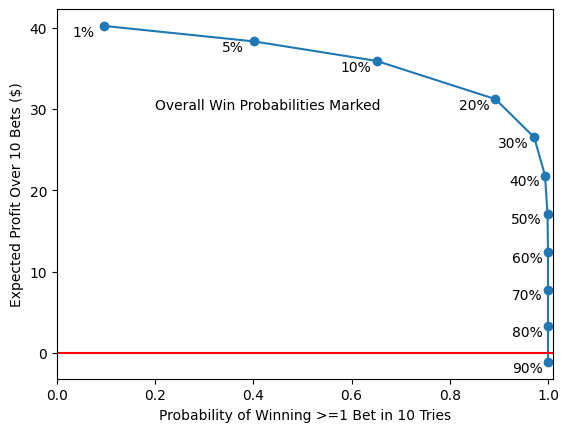

In [21]:
x = df["Prob >=1 Win in {} Bets".format(bet_horizon)]
y = df["Expected Profit per {} Bets".format(bet_horizon)]

plt.plot(x,y, marker='o')
plt.xlabel("Probability of Winning >=1 Bet in {} Tries".format(bet_horizon))
plt.ylabel("Expected Profit Over {} Bets ($)".format(bet_horizon))
plt.xlim([0,1.01])
plt.plot(np.linspace(0,1.01,10), np.zeros(10), color="red")

for i, txt in enumerate(df["Win_Prob (%)"]):
    plt.annotate("{}%".format(txt), (x[i], y[i]), textcoords="offset points", xytext=(-15,-7), ha='center')

plt.annotate("Overall Win Probabilities Marked", xy = (0.2,30))
plt.show()

## Conclusion

Echoing the bottom line provided up-front: the optimal strategy for using the bonus bet promotion is to be aggressive and place bets with long odds, limited only by a desired overall win probability. This trade-off is best balanced by shooting for a win probability of 20%, where the player's bets achieve an expected value of \$3.12. To achieve this, the player sets the odds of the initial and bonus bets set at +760.

Minor updates to come on this project at some point in the future:

1. With the recommended odds of +760 and the probabilistic lens explored in Step 4, revisiting the trade-space for the player's initial wager, $C$.

1. Adjusting the assumption on vig (10.25%), based on the desired true probability of the bet, recognizing that might be only be achieved by adding legs to a parlay bet.

## Archive

In [ ]:
num_probs_to_check = 21
actual_probs = np.linspace(0.01, 0.91, num_probs_to_check, endpoint=True)
bonus_bet_max = 5
vig = 1.05**2
bet = [1, 2.5, 5, 7.5, 10, 20, 50, 100]
num_trials = 20000

rows_list = []

for prob_1 in actual_probs:
  for prob_2 in actual_probs:
    for bet_i in bet:
      bonus_bet = np.min([bonus_bet_max, bet_i])
      bet_info = {}
      implied_prob_1 = min(prob_1 * vig,0.995)
      implied_prob_2 = min(prob_2 * vig,0.995)
      odds_1 = prob_to_odds(implied_prob_1)
      odds_2 = prob_to_odds(implied_prob_2)
      bet_info["Bet"] = bet_i
      bet_info["Prob_1"] = round(prob_1,3)
      bet_info["Implied_Prob_1"] = round(implied_prob_1,3)
      bet_info["Odds_1"] = odds_1
      bet_info["Prob_2"] = round(prob_2,3)
      bet_info["Implied_Prob_2"] = round(implied_prob_2,3)
      bet_info["Odds_2"] = odds_2

      profits = -1*bet_i*np.ones(num_trials)

      for trial in range(num_trials):
        if np.random.rand() < prob_1:
          profits[trial] = profit_calculator(implied_prob_1, bet_i)
          continue

        if np.random.rand() < prob_2:
          profits[trial] = profit_calculator(implied_prob_2, bonus_bet) - bet_i

      bet_info["Expected Profit"] = np.mean(profits)
      bet_info["Median Profit"] = np.median(profits)
      bet_info["Win Perc"] = np.mean(profits > 0)

      rows_list.append(bet_info)

df = pd.DataFrame(rows_list)